In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [97]:
#valores iniciais
p = 1/3
GS_L, GD_L = p*1*10**-9, (1-p)*1*10**-9    #S
G_Na, G_K, G_Ca, G_KCa = p*3*10**-6, p*2*10**-6, (1-p)*2.5*10**-6, (1-p)*5*10**-6  #S
G_KAHP, G_c = (1-p)*0.06*10**-6 , 25*10**-9   #S
E_Na, E_K, E_Ca, E_L = 60*10**-3, -75*10**-3, 80*10**-3, -60*10**-3 #V
CS, CD = p*100*10**-12, (1-p)*100*10**-12 #F
tca = 50*10**-3  #s
k = (1 * 10**6) / (1-p)   #M/C

G_h = 5 * 10**-9
E_h = -20 * 10**-3  #V

In [98]:
#variaveis de gating

#soma
def m_inf(Vs):
    return alpha_m(Vs) / (alpha_m(Vs) + beta_m(Vs))

def h_inf(Vs):
    return alpha_h(Vs) / (alpha_h(Vs) + beta_h(Vs))

def n_inf(Vs):
    return alpha_n(Vs) / (alpha_n(Vs) + beta_n(Vs))

def t_m(Vs):
    return 1 / (alpha_m(Vs) + beta_m(Vs))

def t_h(Vs):
    return 1 / (alpha_h(Vs) + beta_h(Vs))

def t_n(Vs):
    return 1 / (alpha_n(Vs) + beta_n(Vs))

def alpha_m(Vs):
    if Vs == -0.0469:
        return 320000 / 250*np.exp(-250*(Vs+0.0469))
    else:
        return (320 * 10**3 * (Vs + 0.0469)) / (1 - np.exp(-250*(Vs+0.0469)))

def alpha_h(Vs):
    return 128*np.exp(-55.556*(Vs+0.043))

def alpha_n(Vs):
    if Vs == -0.0249:
        return 16000 / 200*np.exp(-200*(Vs+0.0249))
    else:
        return (16 * 10**3 * (Vs+0.0249)) / (1 - np.exp(-200*(Vs+0.0249)))

def beta_m(Vs):
    if Vs == -0.0199:
        return 280000 / 200*np.exp(200*(Vs+0.0199))
    else:
        return 280 * 10**3 * (Vs+0.0199) / (np.exp(200*(Vs+0.0199)) - 1)

def beta_h(Vs):
    return 4000 / (1 + np.exp(-200*(Vs+0.020)))

def beta_n(Vs):
    return 250 * np.exp(-25*(Vs+0.040))


#dendrito
def alpha_mca(Vd):
    return 1600 / (1+np.exp(-72*(Vd-0.005)))

def alpha_mkca(Vd):
    if Vd > -0.010:
        return 2000*np.exp(-37.037*(Vd+0.0535))
    elif Vd <= -0.010:
        return np.exp( ((Vd+0.050)/0.011) - ((Vd+0.0535)/0.027)) / 0.018975

def chi(Ca):
    return min(4000*Ca, 1)

def alpha_mkahp(Ca):
    return min(20, 20000*Ca)

def beta_mca(Vd):
    if Vd == -0.0089:
        return 20000 / 200*np.exp(200*(Vs+0.0089))
    else:
        return 2 * 10**4 * (Vd + 0.0089) / (np.exp(200*(Vd+0.0089)) - 1)

def beta_mkca(Vd):
    if Vd > -0.010:
        return 0
    elif Vd <= -0.010:
        return 2000*np.exp(-(Vd+0.0535)/0.027) - alpha_mkca(Vd)

def mca_inf(Vd):
    return alpha_mca(Vd) / (alpha_mca(Vd) + beta_mca(Vd))

def mkca_inf(Vd):
    return alpha_mkca(Vd) / (alpha_mkca(Vd) + beta_mkca(Vd))

def mkahp_inf(Vd):
    return alpha_mkahp(Vd) / (alpha_mkahp(Vd) + beta_mkahp(Vd))

def t_mca(Vd):
    return 1 / (alpha_mca(Vd) + beta_mca(Vd))

def t_mkca(Vd):
    return 1 / (alpha_mkca(Vd) + beta_mkca(Vd))

def t_mkahp(Vd, Ca):
    return 1 / (alpha_mkahp(Ca) + beta_mkahp(Vd))

def beta_mkahp(Vd):
    return 4

def mh_inf(Vd):
    return 1 / (1 + np.exp(166.667*(Vd+0.070)))

def tmh(Vd):
    return 0.272 + (1.499 / (1 + np.exp(-114.548*(Vd+0.0422))))

In [99]:
#intervalo de tempo
t = np.arange(0, 2, 0.05)

#corrente dentrito
def ID_inj(t):
    I = 0
    ti = 0
    tf = 2
    return I*(t>ti)-I*(t>tf)

#corrente soma
def IS_inj(t):
    I = 0
    ti = 0
    tf = 2
    return I*(t>ti)-I*(t>tf)

#equacoes do modelo
def dALLdt(X, t):
    Vs, Vd, Ca, m, h, n, mca, mkca, mkahp, mh = X
    dVsdt = (IS_inj(t) - GS_L * (Vs-E_L) - G_Na * m**2 * h*(Vs-E_Na) - G_K * n**2 *(Vs-E_K) + G_c * (Vd-Vs)) / CS
    dVddt = (ID_inj(t) - GD_L*(Vd-E_L) - G_Ca * mca**2 * (Vd-E_Ca) - G_KCa * mkca * chi(Ca) * (Vd-E_K) - G_KAHP * mkahp * (Vd-E_K) -G_h*mh*(Vd-E_h) + G_c * (Vs-Vd)) / CD
    dCadt = -(Ca/tca) - k*G_Ca * mca**2 * (Vd-E_Ca)
    dmdt = (m_inf(Vs) - m) / t_m(Vs)
    dhdt = (h_inf(Vs) - h) / t_h(Vs)
    dndt = (n_inf(Vs) - n) / t_n(Vs)
    dmcadt = (mca_inf(Vd) - mca) / t_mca(Vd)
    dmkcadt = (mkca_inf(Vd) - mkca) / t_mkca(Vd)
    dmkahpdt = (mkahp_inf(Vd) - mkahp) / t_mkahp(Vd, Ca)
    dmhdt = (mh_inf(Vd) - mh) / tmh(Vd)

    return dVsdt, dVddt, dCadt, dmdt, dhdt, dndt, dmcadt, dmkcadt, dmkahpdt, dmhdt

In [100]:
#solucoes com valores iniciais
X = odeint(dALLdt, [-60*10**-3, -60*10**-3, 0, 0, 0.5, 0.4, 0, 0.2, 0.2, 0.5], t)
Vs = X[:,0]
Vd = X[:,1]
Ca = X[:,2]
m = X[:,3]
h = X[:,4]
n = X[:,5]
mca = X[:,6]
mkca = X[:,7]
mkahp = X[:,8]
mh = X[:,9]

In [101]:
sol_mhinf = []
sol_tmh = []
val_v = []

for v in range(-100, 1):
    v = v*10**-3
    val_v.append(v)
    sol_mhinf.append(mh_inf(v))
    sol_tmh.append(tmh(v))

val_v = np.array(val_v)

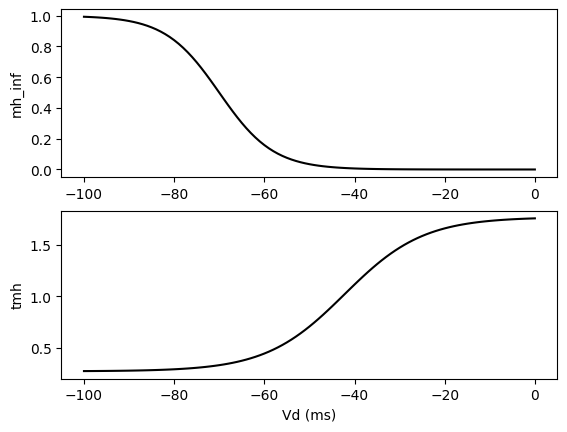

In [102]:
plt.subplot(2,1,1)
plt.plot(val_v*1000, sol_mhinf, 'k')
plt.ylabel('mh_inf')

plt.subplot(2,1,2)
plt.plot(val_v*1000, sol_tmh, 'k')
plt.xlabel('Vd (ms)')
plt.ylabel('tmh')
plt.show()